In [1]:
import pandas as pd
import numpy as np
import spacy
import nltk
from ast import literal_eval
from HanTa import HanoverTagger as ht
from tqdm.auto import tqdm
from collections import Counter
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from typing import List
import re
import pickle
import mgzip
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Sentiment classification of comments

## Lexicon approach

In [2]:
# load command
with mgzip.open('../data/combined_comments_pre.mgzip', 'rb') as handle:
    combined_comments_pre = pickle.load(handle)

In [3]:
combined_comments_pre = combined_comments_pre.reset_index()

In [4]:
senti_merge = pd.read_csv('../resources/sentimerge/data/sentimerge.txt', sep='\t')
senti_merge.drop(['PoS'], axis=1, inplace=True)

In [5]:
senti_merge_pos = senti_merge.loc[senti_merge['sentiment'] > 0]
senti_merge_neg = senti_merge.loc[senti_merge['sentiment'] < 0]

In [6]:
senti_pos_dict = dict(zip(senti_merge_pos['lemma'], senti_merge_pos['sentiment']))
senti_neg_dict = dict(zip(senti_merge_neg['lemma'], senti_merge_neg['sentiment']))
senti_weight_dict = dict(zip(senti_merge['lemma'], senti_merge['weight']))

negation checker inspired by HD students not worth it (https://github.com/text-analytics-20/news-sentiment-development/blob/main/sentiment_analysis/negation_handling.py)

In [7]:
def senti_class(input):
    tmp_list = []
    for word in input:
        if not word:
            continue
        if str(word).lower() in senti_pos_dict:
            tmp_list.append((senti_pos_dict[word.lower()]*senti_weight_dict[word.lower()]))
        if str(word).lower() in senti_neg_dict:
            tmp_list.append((senti_neg_dict[word.lower()]*senti_weight_dict[word.lower()]))
    if not tmp_list:
        return np.nan
    return sum(tmp_list)

In [8]:
def rescale_neg(input):
    return (2 *(input - min(input))/(max(input)-min(input))) - 1

In [9]:
def rescale(input):
    scale = input
    scale -= scale.min()
    scale /= scale.max()
    return scale

In [10]:
def lexi_label(input):
    if input > 1:
        return 'positive'
    elif input < -1:
        return 'negative'
    elif pd.isna(input):
        return np.nan
    else:
        return 'neutral'

In [11]:
combined_comments_pre['lexi_score'] = combined_comments_pre['tokens'].progress_apply(senti_class)

  0%|          | 0/1772864 [00:00<?, ?it/s]

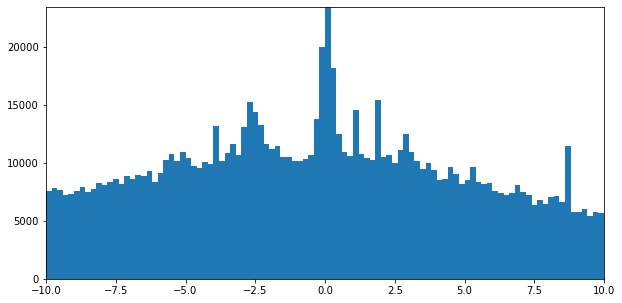

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.margins(0)
plt.hist(combined_comments_pre["lexi_score"].loc[(combined_comments_pre['lexi_score'] > -10) | (combined_comments_pre['lexi_score'] < 10)], bins=100, range=(-10,10))
plt.savefig('../figures/lexi_neutral.png')

In [29]:
combined_comments_pre['lexi_label'] = combined_comments_pre['lexi_score'].apply(lexi_label)

In [30]:
combined_comments_pre['lexi_score'] = rescale(combined_comments_pre['lexi_score'])

In [33]:
combined_comments_lexi = combined_comments_pre[['title', 'lexi_score', 'lexi_label', 'newspaper']]

## BERT approach
This step was calculated on Google Colab cloud due to taking way too long on my laptop.

In [65]:
class SentimentModel():
    def __init__(self, model_name: str):
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.model = AutoModelForSequenceClassification.from_pretrained(model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.clean_chars = re.compile(r'[^A-Za-züöäÖÜÄß ]', re.MULTILINE)
        self.clean_http_urls = re.compile(r'https*\\S+', re.MULTILINE)
        self.clean_at_mentions = re.compile(r'@\\S+', re.MULTILINE)

    @staticmethod
    def probs2polarities(pnn: torch.Tensor) -> torch.Tensor:
        """Transform softmax probs of a [positive, negative, neutral] classifier
        into scalar polarity scores of range [-1, 1].
        High values express positive sentiment, low negative ones negative sentiment.
        Values close to 0 express neutral sentiment."""
        pos = pnn[:, 0]
        neg = pnn[:, 1]
        # Transform range [0, 1] to [-1, 1]
        # Ignore neutrality score as it's implicitly encoded as (1 - pos - neg)
        polarities = pos - neg
        return polarities

    def predict_sentiment(self, texts):
        if np.any(pd.isna(texts)):
          return np.nan
        texts = [self.clean_text(str(text)) for text in [texts]]
        # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
        encoded = self.tokenizer.batch_encode_plus(texts,padding=True, add_special_tokens=True,truncation=True, return_tensors="pt")
        encoded = encoded.to(self.device)
        with torch.no_grad():
                logits = self.model(**encoded)
                probs = torch.nn.functional.softmax(logits[0], dim=1)

        polarities = self.probs2polarities(probs)

        label_ids = torch.argmax(logits[0], axis=1)
        for a in zip(logits[0].tolist(), [self.model.config.id2label[label_id] for label_id in label_ids.tolist()]):
            tmp_rsl = list(a)
        return tmp_rsl, polarities.item()

    def replace_numbers(self,text: str) -> str:
            return text.replace("0"," null").replace("1"," eins").replace("2"," zwei").replace("3"," drei").replace("4"," vier").replace("5"," fünf").replace("6"," sechs").replace("7"," sieben").replace("8"," acht").replace("9"," neun")

    def clean_text(self,text: str)-> str:
            text = text.replace("\n", " ")
            text = self.clean_http_urls.sub('',text)
            text = self.clean_at_mentions.sub('',text)
            text = self.replace_numbers(text)
            text = self.clean_chars.sub('', text) # use only text chars
            text = ' '.join(text.split()) # substitute multiple whitespace with single whitespace
            text = text.strip().lower()
            return text

In [66]:
# oliverguhr/german-sentiment-bert
model = SentimentModel(model_name = "mdraw/german-news-sentiment-bert")

In [107]:
combined_comments_pre['bert'] = combined_comments_pre['value'].progress_apply(model.predict_sentiment)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/multiprocessing/process.py", line 315, in _bootstr

KeyboardInterrupt: 

  File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/pandarallel/data_types/series.py", line 26, in work
    return data.apply(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/pandas/core/apply.py", line 1043, in apply
    return self.apply_standard()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/pandas/core/apply.py", line 1043, in apply
    return self.apply_standard()
  File "pandas/_libs/lib.pyx", line 2859, in pandas._libs.lib.map_infer
  File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/pandas/core/apply.py", line 1098, in apply_standard
    mapped = lib.map_infer(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/pandas/core/apply.py", line 1098, in apply_standard
    mapped = lib.map_infer(
  File "pandas/_libs/lib.pyx", line 2859, in pandas._libs.lib.map_infer
  File "pandas/_lib

In [99]:
def bert_score(input):
    return np.ptp(sorted(list(map(abs, input[0][0]))))

def bert_label(input):
    return input[0][1]

def bert_props(input):
    return input[1]

In [100]:
combined_comments_pre['bert_conf'] = combined_comments_pre['bert'].apply(bert_score)

In [101]:
combined_comments_pre['bert_label'] = combined_comments_pre['bert'].apply(bert_label)

In [102]:
combined_comments_pre['bert_score'] = combined_comments_pre['bert'].apply(bert_props)

In [ ]:
combined_comments_bert = combined_comments_pre[['title', 'bert_score', 'bert_label']]

In [ ]:
with mgzip.open(".../data/comments_bert.mgzip", 'wb') as f:
    pickle.dump(combined_comments_bert, f)

Next steps are combining the individual files created on Google Colab into one combined file.

In [39]:
with mgzip.open('../data/tagesspiegel_bert.mgzip', 'rb') as handle:
    tagesspiegel_bert = pickle.load(handle)
with mgzip.open('../data/zeit_bert.mgzip', 'rb') as handle:
    zeit_bert = pickle.load(handle)
with mgzip.open('../data/welt_bert.mgzip', 'rb') as handle:
    welt_bert = pickle.load(handle)

In [40]:
tagesspiegel_bert['newspaper'] = 'tagespiegel'
zeit_bert['newspaper'] = 'zeit'
welt_bert['newspaper'] = 'welt'

In [43]:
combined_comments_bert = pd.concat([zeit_bert, welt_bert, tagesspiegel_bert])

## Combine lexi & bert

In [56]:
combined_comments_pre['index'] = combined_comments_pre.index

In [58]:
combined_comments_bert['index'] = combined_comments_bert.index

In [87]:
combined_comments_senti = pd.merge(combined_comments_pre, combined_comments_bert[['title', 'index', 'bert_score','bert_label']], on=['title', 'index'], how='left')

In [88]:
combined_comments_senti = combined_comments_senti[['title', 'newspaper', 'variable', 'value', 'lexi_score', 'lexi_label', 'bert_score', 'bert_label']]

In [96]:
# saving preprocessed file
with mgzip.open('../data/combined_comments_senti.mgzip', 'wb') as handle:
    pickle.dump(combined_comments_senti, handle)

## SSentiA

In [97]:
combined_comments_senti['vote'] = np.where((combined_comments_senti['lexi_score'] > combined_comments_senti['bert_score']), 'lexi', 'bert')
combined_comments_senti['vote_score'] = np.where((combined_comments_senti['lexi_score'] > combined_comments_senti['bert_score']), combined_comments_senti['lexi_score'], combined_comments_senti['bert_score'])
combined_comments_senti['vote_label'] = np.where((combined_comments_senti['lexi_score'] > combined_comments_senti['bert_score']), combined_comments_senti['lexi_label'], combined_comments_senti['bert_label'])

In [98]:
combined_comments_senti

,title,newspaper,variable,value,lexi_score,lexi_label,bert_score,bert_label,vote,vote_score,vote_label
0,"Handel: ""Viele brauchen ja eigentlich nichts m...",zeit,Comment0,"\nSehr schönes Interview, Danke!\nEs ist eben ...",0.606474,positive,0.197398,neutral,lexi,0.606474,positive
1,DGB-Index Gute Arbeit: An den Kosten im Homeof...,zeit,Comment0,\nHome Office wo und wann immer möglich UND fa...,0.716222,positive,0.395624,positive,lexi,0.716222,positive
2,Coronavirus: RKI registriert erstmals wieder l...,zeit,Comment0,\nWie ich es voraus gesagt habe.\nEs zeichnete...,0.581695,positive,0.561593,positive,lexi,0.581695,positive
3,Bund-Länder-Runde: Kanzleramtschef fordert Cor...,zeit,Comment0,\nEntfernt. Bitte verzichten Sie auf Unterstel...,0.568505,positive,0.323396,negative,lexi,0.568505,positive
4,Corona-Impfung für Kinder: Gesundheitsminister...,zeit,Comment0,\nWarum schafft man eigentlich nicht endlich d...,0.539759,negative,0.397975,negative,lexi,0.539759,negative
...,...,...,...,...,...,...,...,...,...,...,...
1772859,Inzidenz in Berlin steigt wieder leicht,tagespiegel,Comment6184,"Nach allem, was man hinsichtlich der Entwicklu...",0.530947,negative,0.249955,negative,lexi,0.530947,negative
1772860,Inzidenz in Berlin steigt wieder leicht,tagespiegel,Comment6185,"Man kann nur hoffen,daß dem Berliner Senat mög...",0.568764,positive,0.236482,negative,lexi,0.568764,positive
1772861,Inzidenz in Berlin steigt wieder leicht,tagespiegel,Comment6186,Massentest bringen natürlich etwas: Die Verlau...,0.491317,negative,0.189637,negative,lexi,0.491317,negative
1772862,Inzidenz in Berlin steigt wieder leicht,tagespiegel,Comment6187,"Wenn schon Shutdown, dann richtig. Dann ist di...",0.546551,negative,0.311515,negative,lexi,0.546551,negative


In [2]:
# load command
with mgzip.open('../data/combined_comments_bert.mgzip', 'rb') as handle:
    combined_comments_bert = pickle.load(handle)

In [3]:
combined_comments_bert

,bert,bert_conf,bert_label,bert_score
0,"([[0.34781762957572937, -1.2522820234298706, 1...",1.277788,neutral,0.166603
1,"([[4.476775169372559, -1.91838538646698, -2.86...",2.558390,positive,0.996023
2,"([[3.1189382076263428, 0.8245750069618225, -4....",3.630590,positive,0.816437
3,"([[-1.203690528869629, 3.295466184616089, -2.6...",2.091776,negative,-0.975590
4,"([[-1.3200560808181763, 3.8936355113983154, -3...",2.573579,negative,-0.988513
...,...,...,...,...
76941399,"([[-1.5527026653289795, 2.864715576171875, -1....",1.595653,negative,-0.960944
76953839,"([[-1.5480496883392334, 3.0557596683502197, -1...",1.510323,negative,-0.970524
76966279,"([[-1.0233427286148071, 2.2369704246520996, -1...",1.213628,negative,-0.903010
76978719,"([[-1.4645229578018188, 3.450071096420288, -2....",1.985548,negative,-0.982647
